In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from graspy.embed import AdjacencySpectralEmbed
from graspy.plot import pairplot
from graspy.embed import OutOfSampleAdjacencySpectralEmbed as OOSASE
import graspy

import networkx as nx

import _pickle as pkl
# Need OOS

In [2]:
np.random.seed(1)
reload_data = False

if reload_data:
    nodes = pd.read_csv('nodes', delimiter='\t')
    print(nodes.head())

    edges = pd.read_csv('edges', delimiter='\t',header=None)
    print(edges.head())

    G = nx.from_pandas_edgelist(edges, source=0, target=1)
    lcc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(lcc).copy()
    pkl.dump(G_lcc, open('nas_graph.pkl', 'wb'))
    
    N = len(G_lcc)
    in_sample_prop = 0.2

    nodes = pd.read_csv('nodes', delimiter='\t')['hash']

    in_sample_id = np.random.choice(nodes, int(N*0.2))

    temp_G = G_lcc.subgraph(in_sample_id).copy()
    lcc = max(nx.connected_components(temp_G))

    in_sample_G = temp_G.subgraph(lcc).copy()

    pkl.dump(in_sample_G, open('in_sample_G.pkl', 'wb'))
else:
#     G_lcc = pkl.load(open('nas_graph.pkl', 'rb'))
    in_sample_G = pkl.load(open('in_sample_G.pkl', 'rb'))
    
# print('largest connected component:' + str(len(G_lcc)))
print('in sample size:' + str(len(in_sample_G)))

in sample size:46398


In [ ]:
oos_ase = OOSASE(n_components=100,in_sample_proportion=1, connected_attempts=100, check_lcc=False)
oos_ase.fit(in_sample_G)

in_sample_ids = oos_ase.in_sample_id

X_hat = oos_ase.latent_left_
sing_vals = oos_ase.singular_values_

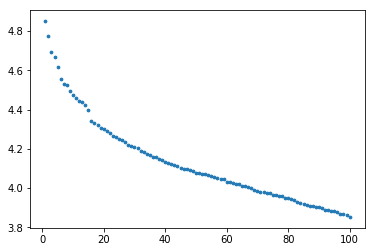

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(range(1, len(sing_vals)+1), sing_vals, s=7.5)

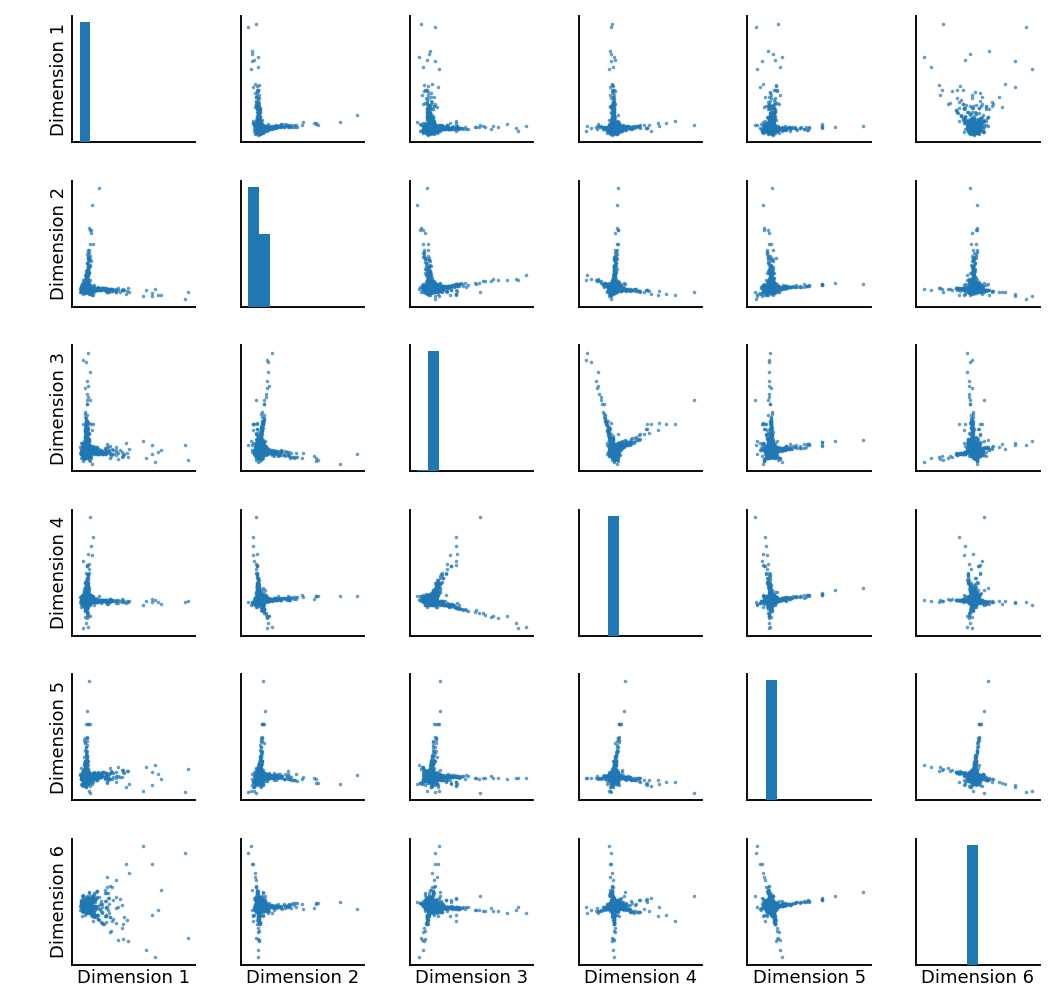

In [6]:
pairplot(X_hat[:, :6])

In [7]:
nodes = pd.read_csv('nodes', delimiter='\t')
node_ids = nodes['hash']
nodes.head()

,hash,mean_final_validation_accuracy,mean_final_training_time
0,00005c142e6f48ac74fdcf73e3439874,0.926416,1768.784953
1,0000718c96730a92ea6d5242f8ce77e2,0.894631,1206.150024
2,0000cb5372fad9d62c470df699ac6d52,0.927350,1343.049967
3,0000fa05697179112aaf69c2f0a51a0f,0.909756,1302.710978
4,00010e19334eb9dcbe1fe61a98d524c2,0.897169,1251.861003


In [8]:
in_sample_nodes = nodes[nodes.hash.isin(oos_ase.in_sample_id)].copy()

from tqdm import tqdm
rearranged_scores = np.zeros(len(in_sample_ids))

for i, id_ in enumerate(tqdm(in_sample_ids)):
    rearranged_scores[i] = in_sample_nodes[in_sample_nodes.hash == id_]['mean_final_validation_accuracy']

100%|██████████| 46398/46398 [02:10<00:00, 356.38it/s]


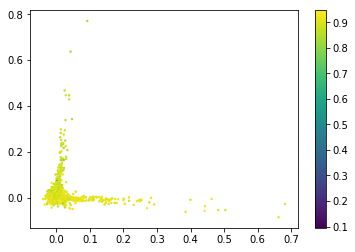

In [9]:
zero_to_one = (rearranged_scores - min(rearranged_scores)) / (max(rearranged_scores) - min(rearranged_scores))

fig, ax = plt.subplots(1,1)
im = ax.scatter(X_hat[:, 0], X_hat[:, 1], c = rearranged_scores, s = 2)
fig.colorbar(im, ax=ax)

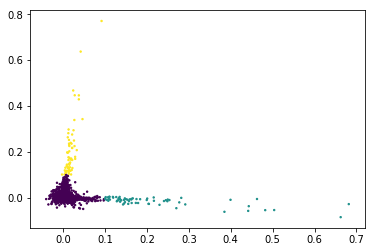

In [10]:
n, d = X_hat[:,:2].shape

fake_labels = -np.ones(n)
for i in range(n):
    if np.sqrt(np.sum(X_hat[i, :2]**2)) < 0.1:
        fake_labels[i] = 0
    elif X_hat[i, 0] > X_hat[i, 1]:
        fake_labels[i] = 1
    else:
        fake_labels[i] = 2
        
fig, ax = plt.subplots(1,1)
im = ax.scatter(X_hat[:, 0], X_hat[:, 1], c = fake_labels, s = 2)

plt.savefig('embedding_3class.png')

In [11]:
X0 = X_hat[:, :2][fake_labels == 0].copy()
Y0 = rearranged_scores[fake_labels == 0].copy()

X1 = X_hat[:, :2][fake_labels == 1].copy()
Y1 = rearranged_scores[fake_labels == 1].copy()

X2 = X_hat[:, :2][fake_labels == 2].copy()
Y2 = rearranged_scores[fake_labels == 2].copy()

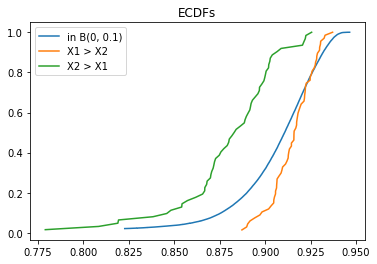

In [15]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

F0 = ecdf(Y0)
F1 = ecdf(Y1)
F2 = ecdf(Y2)

fig, ax = plt.subplots(1,1)
ax.plot(F0[0][1000:], F0[1][1000:], label="in B(0, 0.1)")
ax.plot(F1[0], F1[1], label="X1 > X2")
ax.plot(F2[0], F2[1], label="X2 > X1")
ax.legend()
ax.set_title('ECDFs')
plt.savefig('nas_ecdfs_3class.png')

In [16]:
from scipy.stats import ks_2samp
p01, T01 = ks_2samp(F0[1], F1[1])
p02, T02 = ks_2samp(F0[1], F2[1])
p12, T12 = ks_2samp(F1[1], F2[1])

p01, p02, p12

(0.014925050556076513, 0.016128683665437543, 0.015888300433317293)

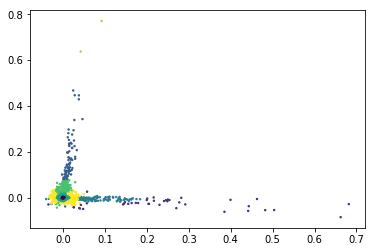

In [20]:
from graspy.cluster import GaussianCluster
gclust = GaussianCluster(min_components=10, covariance_type='all')
Z = gclust.fit_predict(X_hat[:, :2])

fig, ax = plt.subplots(1,1)
ax.scatter(X_hat[:, 0], X_hat[:, 1], c = Z, s = 2)

,spherical,diag,tied,full
1,588447.680805,588440.601226,588431.282184,588431.282184
2,865017.050254,864995.033680,631914.602367,865016.944686
3,893085.625288,877678.436621,672230.858897,878126.294170
4,895821.067326,894696.220273,690355.018707,894908.558058
5,895308.571968,895268.972915,720671.123983,895628.980156
6,895471.148971,896274.840871,737834.355264,895623.036526
7,895827.008132,896253.736001,754985.781476,896441.081123
8,895546.553127,896404.797125,762552.278867,896818.805114
9,895760.656914,896626.370983,773620.454676,896520.290914
10,895572.158598,896497.062177,777100.799422,896543.934448


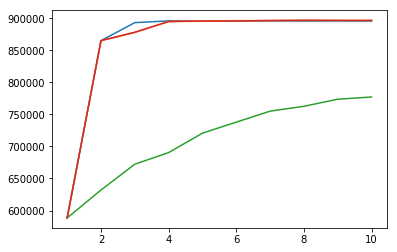

In [26]:
unique_labels = np.unique(Z)
K = len(unique_labels)

fig, ax = plt.subplots(1,1)
for col in gclust.bic_.columns:
    ax.plot(np.arange(1, 11), -gclust.bic_[col], label = col)
-gclust.bic_